In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics import r2_score

chosed_dataset = 'BPI_Challenge_2017'

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_71098/1971721648.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv(f'../data/clean_{chosed_dataset}.csv')

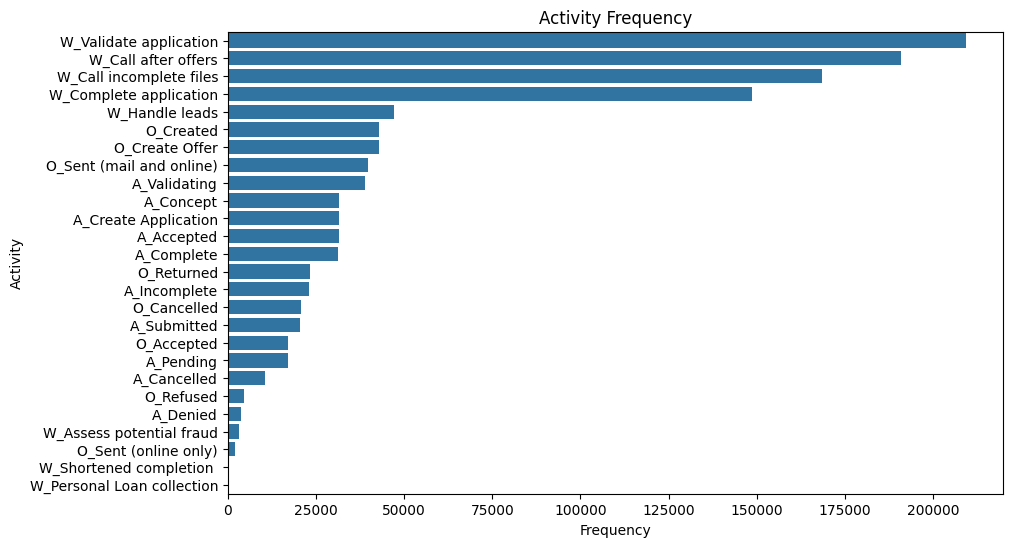

In [3]:
activity_counts = df['concept:name'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=activity_counts.values, y=activity_counts.index)
plt.xlabel('Frequency')
plt.ylabel('Activity')
plt.title('Activity Frequency')
plt.show()

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_71098/465484979.py:3: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  case_durations = df.groupby('case:concept:name')['time:timestamp'].agg([min, max])
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_71098/465484979.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  case_durations = df.groupby('case:concept:name')['time:timestamp'].agg([min, max])


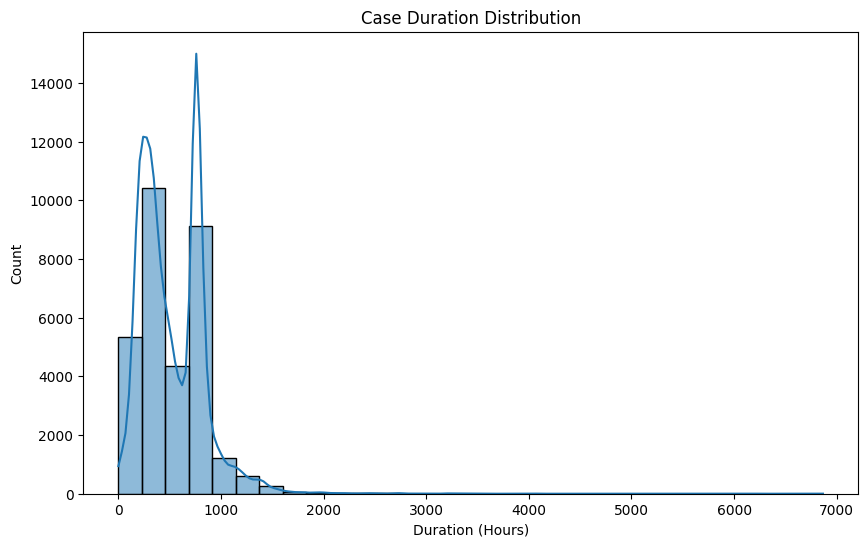

In [4]:
# Assuming 'time:timestamp' is the timestamp and 'case:concept:name' is the case ID
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])
case_durations = df.groupby('case:concept:name')['time:timestamp'].agg([min, max])
case_durations['duration'] = (case_durations['max'] - case_durations['min']).dt.total_seconds() / 3600  # Duration in hours

plt.figure(figsize=(10, 6))
sns.histplot(case_durations['duration'], bins=30, kde=True)
plt.xlabel('Duration (Hours)')
plt.ylabel('Count')
plt.title('Case Duration Distribution')
plt.show()


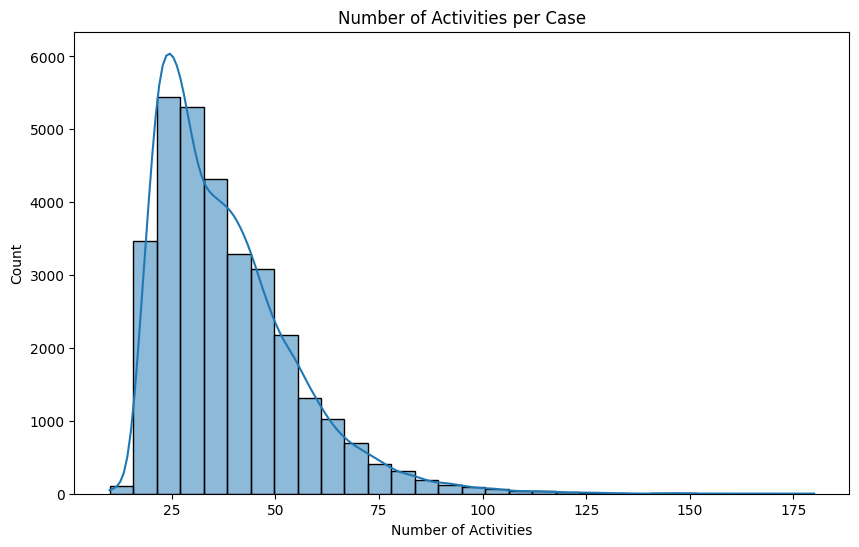

In [5]:
activities_per_case = df.groupby('case:concept:name').size()

plt.figure(figsize=(10, 6))
sns.histplot(activities_per_case, bins=30, kde=True)
plt.xlabel('Number of Activities')
plt.ylabel('Count')
plt.title('Number of Activities per Case')
plt.show()


Text(0, 0.5, 'Frequency')

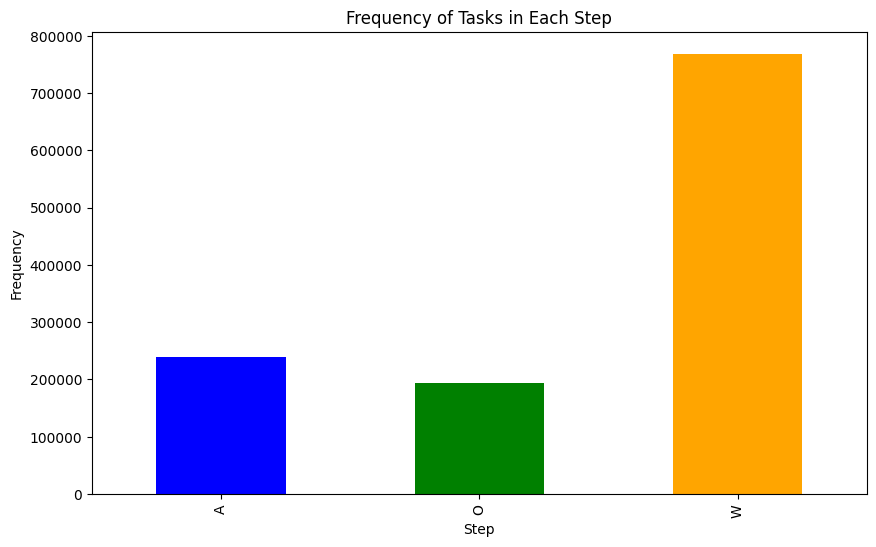

In [6]:
# Extract prefixes ('W_', 'O_', 'A_')
df['prefix'] = df['concept:name'].str.split('_').str[0]

# Create separate columns for each step
df['W'] = df['prefix'].apply(lambda x: x == 'W')
df['O'] = df['prefix'].apply(lambda x: x == 'O')
df['A'] = df['prefix'].apply(lambda x: x == 'A')

# Plot the frequency of tasks chosen at each step
fig, ax = plt.subplots(figsize=(10, 6))

df.groupby('prefix').size().plot(kind='bar', color=['blue', 'green', 'orange'], ax=ax)
ax.set_title('Frequency of Tasks in Each Step')
ax.set_xlabel('Step')
ax.set_ylabel('Frequency')

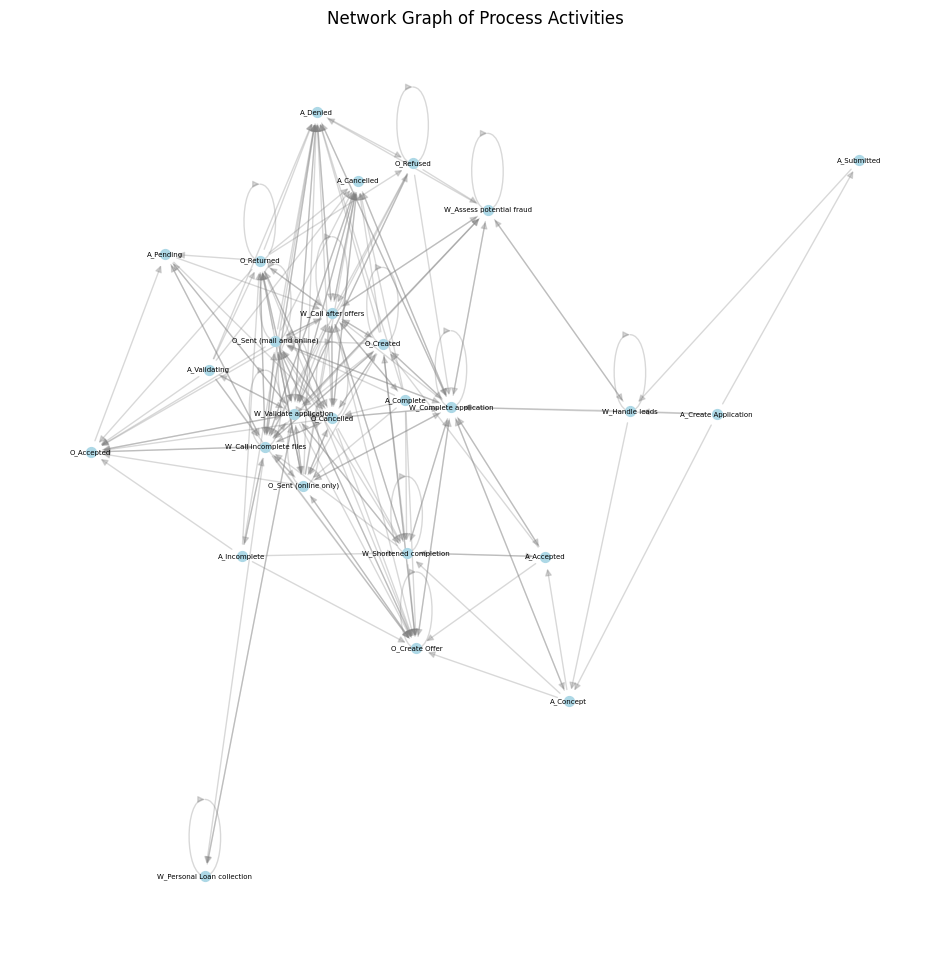

In [7]:
# Create a directed graph
G = nx.DiGraph()

# Add edges for transitions between activities for each case
# Here, we'll track the last activity to create a sequence within each case
last_activity = {}

for index, row in df.iterrows():
    case_id = row['case:concept:name']
    activity = row['concept:name']
    
    # Check if the current case had a previous activity
    if case_id in last_activity:
        # Add edge from last activity to current activity for the same case
        G.add_edge(last_activity[case_id], activity)
    
    # Update the last activity for the current case
    last_activity[case_id] = activity

# Use a spring layout to visualize the graph, attempting to reflect some hierarchy or sequence
pos = nx.spring_layout(G, seed=42)  # Seed for reproducible layout

# Drawing the graph
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color="lightblue")
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=5, font_family="sans-serif")

plt.title("Network Graph of Process Activities")
plt.axis("off")  # Turn off the axis
plt.show()

# Creation of Naive Model

In [8]:
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])

# Generate event sequence numbers within each case
df['event_seq'] = df.groupby('case:concept:name').cumcount() + 1

# Calculate the difference between the current event's timestamp and the next one
df['time_to_next_event'] = df.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.diff().shift(-1))

# Convert the 'time_to_next_event' from timedelta to seconds (or any other numeric representation you prefer)
df['time_to_next_event_seconds'] = df['time_to_next_event'].dt.total_seconds().fillna(0)

# Step 2: Compute the mean duration for each 'concept:name'
average_durations_per_concept = df[['time_to_next_event_seconds', 'concept:name']].groupby('concept:name').median().rename(columns={'time_to_next_event_seconds': 'mean_duration_seconds'})

# Step 3: Merge this mean duration back into the original dataframe to use as a prediction
df = pd.merge(df, average_durations_per_concept, how='left', on='concept:name')

# Rename the 'mean_duration_seconds' column to something like 'predicted_duration_seconds'
df.rename(columns={'mean_duration_seconds': 'predicted_time_to_next_event_seconds'}, inplace=True)

df[['predicted_time_to_next_event_seconds', 'time_to_next_event_seconds']] = df[['predicted_time_to_next_event_seconds', 'time_to_next_event_seconds']].round(2)

# Optionally, convert the 'predicted_time_to_next_event_seconds' back to a timedelta for readability or further datetime operations
# dataframe_2012['predicted_time_to_next_event'] = pd.to_timedelta(dataframe_2012['predicted_time_to_next_event_seconds'], unit='s')

df

,Unnamed: 0,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,...,start_timestamp,timestamp_difference,prefix,W,O,A,event_seq,time_to_next_event,time_to_next_event_seconds,predicted_time_to_next_event_seconds
0,0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304,Existing loan takeover,New credit,...,2016-01-01 09:51:15.304000+00:00,NaN,A,False,False,True,1,0 days 00:00:00.048000,0.05,0.04
1,1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352,Existing loan takeover,New credit,...,2016-01-01 09:51:15.352000+00:00,0 days 00:00:00.048000,A,False,False,True,2,0 days 00:00:00.422000,0.42,0.30
2,2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774,Existing loan takeover,New credit,...,2016-01-01 09:51:15.774000+00:00,0 days 00:00:00.422000,W,True,False,False,3,0 days 00:01:20.618000,80.62,34.08
3,3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392,Existing loan takeover,New credit,...,2016-01-01 09:52:36.392000+00:00,0 days 00:01:20.618000,W,True,False,False,4,0 days 00:00:00.011000,0.01,34.08
4,4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403,Existing loan takeover,New credit,...,2016-01-01 09:52:36.403000+00:00,0 days 00:00:00.011000,W,True,False,False,5,0 days 00:00:00.010000,0.01,3.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201085,1071364,statechange,User_131,A_Validating,Application,ApplState_1576288280,complete,2017-02-01 14:00:30.347,Existing loan takeover,New credit,...,2017-02-01 14:00:30.347000+00:00,0 days 00:00:00.072000,A,False,False,True,80,0 days 00:00:53.844000,53.84,26.08
1201086,1071365,Released,User_131,W_Validate application,Workflow,Workitem_997581455,suspend,2017-02-01 14:01:24.191,Existing loan takeover,New credit,...,2017-02-01 14:01:24.191000+00:00,0 days 00:00:53.844000,W,True,False,False,81,NaT,0.00,0.84
1201087,1169224,Released,User_56,W_Call incomplete files,Workflow,Workitem_1421607593,suspend,2017-02-01 14:09:03.331,"Other, see explanation",New credit,...,2017-02-01 14:09:03.331000+00:00,0 days 00:18:06.767000,W,True,False,False,36,NaT,0.00,70.51
1201088,1191694,Obtained,User_100,W_Validate application,Workflow,Workitem_1317562192,resume,2017-02-01 14:10:52.793,Existing loan takeover,New credit,...,2017-02-01 14:10:52.793000+00:00,0 days 00:16:49.249000,W,True,False,False,53,0 days 00:00:10.706000,10.71,0.84


In [9]:
df = df.drop(columns=['column_similarity_percentage'], errors='ignore')

# Subtract the timestamp of the first event in each case from all events in that case
df['elapsed_time_from_start'] = df.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x - x.min())

# Calculate the average elapsed time from the start for each 'event_seq'
predicted_start_time = df.groupby('event_seq')['elapsed_time_from_start'].mean().reset_index(name='predicted_start_time')

# Merge this average elapsed time back into the original DataFrame to use as a predicted start time
df = pd.merge(df, predicted_start_time, on='event_seq', how='left')

In [10]:
# Step 1: Shift the 'concept:name' within each group to get the next step
# dataframe_2012['next_step'] = dataframe_2012.groupby('case:concept:name')['concept:name'].shift(-1)

# Step 2: For each 'concept:name', calculate the most common next step
# We'll group by 'concept:name' and then use value_counts on 'next_step' to find the most common follow-up step
#most_common_next_steps = dataframe_2012.groupby('concept:name')['next_step'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(n

# Merge the most common next step back into the original DataFrame
#dataframe_2012 = pd.merge(dataframe_2012, most_common_next_steps, how='left', on='concept:name')

# Rename the merged column to 'predicted_next_step'
#dataframe_2012.rename(columns={'most_common_next_step': 'predicted_next_step'}, inplace=True)

In [11]:
# Calculate the most common concept:name for each event_seq
most_common_concepts_by_seq = df.groupby('event_seq')['concept:name'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(name='predicted_step')

# Merge the most common concept:name for each event_seq back into the original DataFrame
df = pd.merge(df, most_common_concepts_by_seq, on='event_seq', how='left')

In [12]:
df['column_similarity_percentage'] = (df['concept:name'] == df['predicted_step']).mean() * 100

# accuracy for label prediction
accuracy = df['column_similarity_percentage'].loc[0]

# r2 for time prediction
r2_time = r2_score(df['time_to_next_event_seconds'], df['predicted_time_to_next_event_seconds'])

# rename columns with predictions
df = df.rename(columns={'predicted_step': 'next concept:name naive', 'predicted_time_to_next_event_seconds': 'next time:timestamp naive', 'time_to_next_event': 'next time:timestamp', 'timestamp_difference': 'time:timestamp diff'}, errors='ignore')

# convert the times back to timestamps
df['next time:timestamp'] = df['time:timestamp'] + df['next time:timestamp']
df['next time:timestamp naive'] = pd.to_timedelta(df['next time:timestamp naive'], unit='s')
df['next time:timestamp naive'] = df['time:timestamp'] + df['next time:timestamp naive']
df['next concept:name naive'] = df.groupby('case:concept:name')['next concept:name naive'].shift(-1)

# drop columns that are not going to be used
df = df.drop(columns=['column_similarity_percentage', 'predicted_start_time', 'elapsed_time_from_start', 'time_to_next_event_seconds', 'event_seq', 'A', 'O', 'W', 'prefix'], errors='ignore')

# save to the csv 
df.to_csv(f"../data/{chosed_dataset}_naive.csv")

print(f"""
    Metrics for Baseline model (Naive Model):\n
    Accuracy for next event prediction: {accuracy}% \n
    R\u00B2 of time prediction for next event: {r2_time}
""")


    Metrics for Baseline model (Naive Model):

    Accuracy for next event prediction: 44.767169820746155% 

    R² of time prediction for next event: -0.0450917981615675



In [13]:
df

,Unnamed: 0,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,...,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,start_timestamp,time:timestamp diff,next time:timestamp,next time:timestamp naive,next concept:name naive
0,0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.304000+00:00,NaN,2016-01-01 09:51:15.352,2016-01-01 09:51:15.344,A_Submitted
1,1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.352000+00:00,0 days 00:00:00.048000,2016-01-01 09:51:15.774,2016-01-01 09:51:15.652,W_Handle leads
2,2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.774000+00:00,0 days 00:00:00.422000,2016-01-01 09:52:36.392,2016-01-01 09:51:49.854,W_Handle leads
3,3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:52:36.392000+00:00,0 days 00:01:20.618000,2016-01-01 09:52:36.403,2016-01-01 09:53:10.472,W_Complete application
4,4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:52:36.403000+00:00,0 days 00:00:00.011000,2016-01-01 09:52:36.413,2016-01-01 09:52:40.113,A_Concept
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201085,1071364,statechange,User_131,A_Validating,Application,ApplState_1576288280,complete,2017-02-01 14:00:30.347,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,2017-02-01 14:00:30.347000+00:00,0 days 00:00:00.072000,2017-02-01 14:01:24.191,2017-02-01 14:00:56.427,W_Call incomplete files
1201086,1071365,Released,User_131,W_Validate application,Workflow,Workitem_997581455,suspend,2017-02-01 14:01:24.191,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,2017-02-01 14:01:24.191000+00:00,0 days 00:00:53.844000,NaT,2017-02-01 14:01:25.031,NaN
1201087,1169224,Released,User_56,W_Call incomplete files,Workflow,Workitem_1421607593,suspend,2017-02-01 14:09:03.331,"Other, see explanation",New credit,...,NaN,NaN,NaN,NaN,NaN,2017-02-01 14:09:03.331000+00:00,0 days 00:18:06.767000,NaT,2017-02-01 14:10:13.841,NaN
1201088,1191694,Obtained,User_100,W_Validate application,Workflow,Workitem_1317562192,resume,2017-02-01 14:10:52.793,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,2017-02-01 14:10:52.793000+00:00,0 days 00:16:49.249000,2017-02-01 14:11:03.499,2017-02-01 14:10:53.633,W_Call incomplete files
